## 9-11. 프로젝트: 네이버 영화리뷰 감성분석 도전하기

## Library import

In [1]:
import pandas as pd
import tensorflow as tf
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


## Data loader 
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 **word_to_index** 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

## index_to_word 생성
- **word_to_index**를 활용하여 새로운 **index_to_word** 생성
- 그 외에 인덱스를 입려하면 단어로 리턴해주는 함수, 단어를 입력하면 인덱스로 리턴해주는 함수 정의

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [8]:
X_test.shape

(49157, 41)

##  validation set 구성 및 모델선정

**validation set 구성**

In [9]:
len(X_train)

146182

In [10]:
# validation set 20000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지
partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(126182, 41)
(126182,)
(20000, 41)
(20000,)


**Model 선정**
- 같은 파라미터로 3가지 모델을 학습
    1. 1-D CNN
    2. LSTM
    3. GlobalMaxPooling1D
- 이후에 가장 성능이 좋은 모델 선택 후 파라미터 튜닝을 수행

In [11]:
# 세가지 모델을 평가할 때, 파라미터는 고정으로 사용
vocab_size = len(index_to_word)
word_vector_dim = 300

**1-D CNN**

In [12]:
# CNN

CNN_model = keras.Sequential(name="CNN")
CNN_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(keras.layers.Conv1D(256, 7, activation='relu'))
CNN_model.add(keras.layers.MaxPooling1D(5))
CNN_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
CNN_model.add(keras.layers.GlobalMaxPooling1D())
CNN_model.add(keras.layers.Dense(8, activation='relu'))
CNN_model.add(keras.layers.Dense(1, activation='sigmoid'))
CNN_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         537856    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 256)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          114752    
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9       

**LSTM**

In [13]:
# LSTM

LSTM_model = keras.Sequential(name="LSTM")
LSTM_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(keras.layers.LSTM(8, dropout=0.7))
LSTM_model.add(keras.layers.Dense(8, activation='relu'))
LSTM_model.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 9888      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


**GlobalMaxPooling1D**

In [14]:
# GlobalMaxPooling1D

GMP_model = keras.Sequential(name="GMP")
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))

GMP_model.summary()


Model: "GMP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


**3가지 모델을 같은 조건에서 학습 후 결과 확인**

In [15]:
model_lst = [CNN_model.name, LSTM_model.name, GMP_model.name]
model_lst

['CNN', 'LSTM', 'GMP']

In [16]:
model_result = {}

for model_name in model_lst:
    
    if model_name == "CNN":
        model = CNN_model
    elif model_name == "LSTM":
        model = LSTM_model
    else :
        model = GMP_model
    
    print('-'*40)
    print("Start fitting {} ...".format(model_name))
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epochs=20

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    
    
    print("Start evaluating {} ...".format(model_name))
    results = model.evaluate(X_test,  y_test, verbose=2)
    model_result[model_name] = results

----------------------------------------
Start fitting CNN ...
Epoch 1/20
247/247 [==============================] - 16s 64ms/step - loss: 0.4036 - accuracy: 0.8061 - val_loss: 0.3319 - val_accuracy: 0.8539
Epoch 2/20
247/247 [==============================] - 10s 40ms/step - loss: 0.2773 - accuracy: 0.8850 - val_loss: 0.3198 - val_accuracy: 0.8619
Epoch 3/20
247/247 [==============================] - 10s 41ms/step - loss: 0.1862 - accuracy: 0.9271 - val_loss: 0.3631 - val_accuracy: 0.8523
Epoch 4/20
247/247 [==============================] - 10s 40ms/step - loss: 0.0999 - accuracy: 0.9648 - val_loss: 0.4649 - val_accuracy: 0.8510
Epoch 5/20
247/247 [==============================] - 9s 38ms/step - loss: 0.0567 - accuracy: 0.9803 - val_loss: 0.6056 - val_accuracy: 0.8453
Epoch 6/20
247/247 [==============================] - 9s 38ms/step - loss: 0.0379 - accuracy: 0.9867 - val_loss: 0.7201 - val_accuracy: 0.8442
Epoch 7/20
247/247 [==============================] - 9s 37ms/step - loss: 

Epoch 16/20
247/247 [==============================] - 7s 27ms/step - loss: 0.0086 - accuracy: 0.9964 - val_loss: 0.7486 - val_accuracy: 0.8424
Epoch 17/20
247/247 [==============================] - 7s 27ms/step - loss: 0.0077 - accuracy: 0.9967 - val_loss: 0.7700 - val_accuracy: 0.8425
Epoch 18/20
247/247 [==============================] - 7s 27ms/step - loss: 0.0073 - accuracy: 0.9968 - val_loss: 0.7909 - val_accuracy: 0.8424
Epoch 19/20
247/247 [==============================] - 7s 27ms/step - loss: 0.0069 - accuracy: 0.9969 - val_loss: 0.8027 - val_accuracy: 0.8440
Epoch 20/20
247/247 [==============================] - 7s 27ms/step - loss: 0.0068 - accuracy: 0.9969 - val_loss: 0.8206 - val_accuracy: 0.8402
Start evaluating GMP ...
1537/1537 - 2s - loss: 0.8352 - accuracy: 0.8380


In [17]:
for name, [_, acc] in sorted(model_result.items(), key=lambda x : x[1][1], reverse=True) :
    print(name,'\t',acc)

LSTM 	 0.8501942753791809
GMP 	 0.8379681706428528
CNN 	 0.8366255164146423


## 모델 훈련
- 위 모델 중 **LTSM**의 성능이 가장 좋았음
- 모델 훈련하기 전에 성능을 올릴 수 있는 최적의 하이퍼파라미터 값을 찾아봄

**최적의 모델 만들기**
- LSTM모델 앞에 CNN을 추가도 해보았고, LSTM을 추가도 해보았다.
    - CNN의 경우는 추가를 하면 성능이 더 나빴다.
    - LSTM층을 하나 더 추가할 경우 결과는 크게 달라지지 않았지만 학습 곡선이 다르게 나타나는 것을 알 수 있었다.
- 간단하게 LSTM 레이어 하나만을 사용해서 하이퍼파라미터를 튜닝해보도록 하였다.
    - word_vector_dim 을 늘려가면서 성능이 점점 더 좋아지는 것을 알 수 있었다.
        - 1000
    - LSTM 레이어의 벡터 차원수를 기존에 8에서 128까지 늘렸다.
    - input dimension이 1000개에 반해 128개의 차원은 여전히 부족하지 않을까?
    - Overfitting이 자주 발생하여서 LSTM의 인자로 Dropout도 추가하였다.


In [18]:
word_vector_dim = 1000  # 워드 벡터의 차원수

'''
# LSTM 기존 모델
 
word_vector_dim = 300 

LSTM_model = keras.Sequential(name="LSTM")
LSTM_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(keras.layers.LSTM(8, dropout=0.7))
LSTM_model.add(keras.layers.Dense(8, activation='relu'))
LSTM_model.add(keras.layers.Dense(1, activation='sigmoid'))
'''

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# CNN을 추가했을 때
# model.add(keras.layers.Conv1D(8, 7, activation='relu'))
# model.add(keras.layers.MaxPooling1D())
# LSTM 레이어를 두개로 학습했을 때
# model.add(keras.layers.LSTM(256, dropout=0.7, return_sequences=True))
model.add(keras.layers.LSTM(128, dropout=0.7))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 이진분류

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 1000)        10000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               578048    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 10,579,089
Trainable params: 10,579,089
Non-trainable params: 0
_________________________________________________________________


- 이전에 20번 epoch을 돌리는 동안 **validation loss**값이 오르는 것을 확인 **(Overfitting 발생)** 

- 그 결과, **callback의 EarlyStopping**을 사용하였고 최적의 모델을 저장하기 위해서 **ModelCheckpoint**를 사용하였다

In [19]:
import tensorflow as tf

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model_check = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

**Model compile**
- optimizer에서 사용하는 Adam에도 learning rate를 조절
- 이전에 세가지 모델을 학습시켜보았을 때 여러번 학습이 진행되기 전에 Overfitting이 발생하였기 때문에 학습률을 낮춤
- 추가적으로 배치사이즈도 더 작게 설정

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                   callbacks=[early_stopping, model_check])

Epoch 1/20
986/986 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.7686
Epoch 00001: val_accuracy improved from -inf to 0.85000, saving model to model.h5
986/986 [==============================] - 75s 76ms/step - loss: 0.4486 - accuracy: 0.7686 - val_loss: 0.3425 - val_accuracy: 0.8500
Epoch 2/20
986/986 [==============================] - ETA: 0s - loss: 0.3265 - accuracy: 0.8591
Epoch 00002: val_accuracy improved from 0.85000 to 0.85920, saving model to model.h5
986/986 [==============================] - 75s 76ms/step - loss: 0.3265 - accuracy: 0.8591 - val_loss: 0.3273 - val_accuracy: 0.8592
Epoch 3/20
986/986 [==============================] - ETA: 0s - loss: 0.2896 - accuracy: 0.8760
Epoch 00003: val_accuracy improved from 0.85920 to 0.86510, saving model to model.h5
986/986 [==============================] - 74s 75ms/step - loss: 0.2896 - accuracy: 0.8760 - val_loss: 0.3168 - val_accuracy: 0.8651
Epoch 4/20
986/986 [==============================] - ETA: 0s

In [21]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3462 - accuracy: 0.8601
[0.34623509645462036, 0.8601012825965881]


## Loss, Accuracy 그래프 시각화

In [22]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


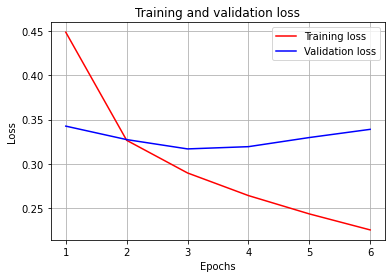

In [23]:

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

## 학습된 Embedding 레이어 분석

In [24]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 1000)


In [25]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀작성

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close() 

- gensim을 사용해서 학습시킨 word2vector를 사용해서 대박이라는 단어와 연관성이 있는 단어들을 뽑아 봄
- 영화 리뷰라고 생각해보았을 때, 긍정적인 평가들이 나오는 것을 확인

In [26]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['대박']
# vector

In [27]:
word_vectors.similar_by_word("대박")

[('괜춘', 0.5811702013015747),
 ('올려야', 0.5804870128631592),
 ('뗄', 0.5663620233535767),
 ('담백', 0.5601297616958618),
 ('감독판', 0.5591539144515991),
 ('독도', 0.5563544631004333),
 ('놀라웠', 0.551439642906189),
 ('구할', 0.5499293804168701),
 ('각지', 0.5498082041740417),
 ('미남', 0.5493574142456055)]

## 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.
- https://github.com/Kyubyong/wordvectors

In [28]:
os.listdir('/home/aiffel0042/aiffel/sentiment_classification')

['word2vec.txt', 'ratings_test.txt', 'ko.tsv', 'ko.bin', 'ratings_train.txt']

In [29]:
os.getenv('HOME')+'/aiffel/sentiment_classification/ko.tsv'

'/home/aiffel0042/aiffel/sentiment_classification/ko.tsv'

In [30]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'

**기존의 코드**    
- from gensim.models.keyedvectors import Word2VecKeyedVectors     
- word2vec = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

**bin** 파일로 저장되어 있는 **word2vec** 불러오기 위해 아래와 같이 사용

In [31]:
from gensim.models import Word2Vec

word2vec = Word2Vec.load(word2vec_file_path)

In [32]:
vector = word2vec['대박']
vector

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.12250227, -0.26166117,  0.1601894 ,  0.24988233, -0.19694664,
        0.20742898,  0.23358916, -0.08032743,  0.07419734,  0.28976992,
        0.05920417, -0.24217431,  0.42650384,  0.37083197,  0.01488842,
       -0.15399031,  0.21594983,  0.16782928,  0.04716487, -0.3933347 ,
        0.06105555, -0.13588727, -0.0257909 , -0.06074918,  0.04168789,
        0.34588724,  0.24693313, -0.05122459,  0.16371667,  0.05747311,
       -0.12627307, -0.16464052, -0.29741055,  0.17121391, -0.24180788,
       -0.28056645, -0.06616814,  0.15681611,  0.20206362, -0.1660444 ,
        0.00203782, -0.2563252 , -0.24074501, -0.63730514,  0.35244125,
        0.05436644, -0.14913762, -0.06556495, -0.05610788,  0.11254067,
       -0.09251513, -0.28059378,  0.07197419,  0.11595767,  0.15117767,
       -0.00541334, -0.128903  ,  0.04034068, -0.22690742,  0.00775241,
        0.16708778,  0.10937496, -0.17221814,  0.04758313,  0.321897  ,
        0.0646909 ,  0.292136  , -0.07984147,  0.09785581,  0.18

위에서 불러온 **word2vec** 사용하여 **embedding_matrix** 생성

In [33]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


- 위에서 만든 임베딩을 여기서 학습하는데 활용
- 모델은 위에서 사용한것과 동일하게 LSTM을 사용하였고 LSTM 레이어의 차원도 128로 설정
- 여기서 Embedding 레이어에 embedding_matrix로 초기화를 해주었기 때문에 **word_vector_dim**과 같은 경우는 **기존에 초기화 되어있는 임베딩의 차원인 200**으로 줌

In [36]:
from keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(keras.layers.LSTM(256))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


In [37]:
# 학습의 진행
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                   callbacks=[early_stopping, model_check])

Epoch 1/20
985/986 [============================>.] - ETA: 0s - loss: 0.4871 - accuracy: 0.7378
Epoch 00001: val_accuracy did not improve from 0.86725
986/986 [==============================] - 19s 19ms/step - loss: 0.4870 - accuracy: 0.7379 - val_loss: 0.3536 - val_accuracy: 0.8467
Epoch 2/20
984/986 [============================>.] - ETA: 0s - loss: 0.3192 - accuracy: 0.8627
Epoch 00002: val_accuracy did not improve from 0.86725
986/986 [==============================] - 18s 19ms/step - loss: 0.3192 - accuracy: 0.8627 - val_loss: 0.3179 - val_accuracy: 0.8635
Epoch 3/20
985/986 [============================>.] - ETA: 0s - loss: 0.2749 - accuracy: 0.8846
Epoch 00003: val_accuracy did not improve from 0.86725
986/986 [==============================] - 19s 19ms/step - loss: 0.2749 - accuracy: 0.8846 - val_loss: 0.3142 - val_accuracy: 0.8663
Epoch 4/20
985/986 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.9010
Epoch 00004: val_accuracy improved from 0.86725 to 0

In [38]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3878 - accuracy: 0.8625
[0.38776037096977234, 0.8625018000602722]


- **validation accurary**가 **0.002** 증가

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


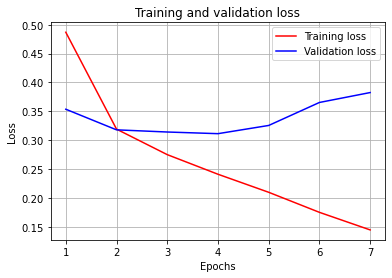

In [39]:
history_dict = history.history
print(history_dict.keys())

# 시각화를 시도한다.
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

## 정리
- 세 가지 모델을 사용
    1. **1D CNN** : 0.8413
    2. **LSTM** : 0.8424
    3. **GlobalMaxPooling1D** : 0.8402   
<br/>    
- 그 중에서 제일 좋은 **LSTM**으로 선택 -> 모델 구조 찾기
    - 하이퍼 파라미터를 튜닝하기 전, 모델 구조에 대해 파악
        1. CNN 1D -> LSTM
        2. LSTM -> LSTM
        3. LSTM 단일 레이어    
    - 하지만 CNN을 추가한 경우 생각보다 점수가 낮게 나오고 LSTM 레이어를 두개를 사용해도 성능은 나아지지 않음    
<br/>      
- 하이퍼 파라미터 설정
    - word_vector_dim = 1000
    - LSTM 레이어의 차원 수 = 128, dropout = 0.7 적용
    - Adam optimizer의 learning rate = 0.0005
    - batch_size = 128  
<br/>    
- Callback 함수 사용
    - EearlyStopping
    - Checkpoint    
<br/>    
     
**정확도** 0.84 -> 0.86
- 약 2퍼센트 향상